# Training a model

Below is the example for a Gaussian Process classification example using GpyTorch :class:`.VariationalGaussianProcessClassifier`

This example shows how to use a AdditiveGridInducingVariationalGP module. This classifcation module is designed for when the function you’re modeling has an additive decomposition over dimension.

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

# High-level imports
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make inline plots
%matplotlib inline

In [2]:
# Generate toy dataset
from torch.autograd import Variable

# Classifying points
# X is [-1, 1] X [-1, 1] 
# Y values are 1 inside [-0.5, 0.5] X [-0.5, 0.5]
# 201 points along each axis, 201^2 = 40,401 training points
n = 201
train_x = torch.zeros(n ** 2, 2)
train_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
train_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
train_y = (train_x[:, 0].abs().lt(0.5)).float() * (train_x[:, 1].abs().lt(0.5)).float() * 2 - 1
# Cuda the variables
train_x = Variable(train_x)
train_y = Variable(train_y)

In [3]:
# Neural net and optimizer imports
from torch import nn, optim
# Get the RBF kernel
# The GridInterpolationKernel is put on top the RBF kernel to interpolate it between
# the grid inducing points
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
# Gaussian likelihood is a Gaussian with noise added
# Bernoulli likelihood (warping input using normal CDF to [0,1])
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import VariationalGaussianProcessClassifier

In [4]:
# Step 1: Define the GP model
# For GP Classification we use the AdditiveGridInducingVariationalGP model
class GPClassificationModel(gpytorch.models.AdditiveGridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=100, grid_bounds=[(-2, 2)],
                                                    n_components=2)
        # Constant mean near 0
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        # RBF kernel used as covariance module
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        # Register the log length scale of the RBF kernel as a parameter to be trained
        self.register_parameter('log_outputscale',
                                nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Use the mean and covariance modules
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Scale the covariance matrix by lengthscale
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # The prediction is in the form of a Gaussian Random variable
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

In [5]:
# Step 2: Wrap the model into our GP Wrapper
GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
    max_epochs = 25,
    lr = 0.2
)

# Step 3: Find optimal model hyperparameters
# See dkl_mnist.ipynb for explanation of use_toeplitz
with gpytorch.settings.use_toeplitz(False):
    GPWrapper.fit(X=train_x, y=train_y)

# Step 4: Prediction
# Test x are regularly spaced by 0.01 0,1 inclusive
# 10k test points on grid
n = 100
test_x = torch.zeros(n ** 2, 2)
test_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
test_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
with gpytorch.settings.use_toeplitz(False):
    observed_pred = GPWrapper.predict_proba(X=test_x)  

  epoch    train_loss     dur
-------  ------------  ------
      1        6.2742  1.0588
      2        6.6928  1.3746
      3        8.5827  1.2021
      4        3.9710  1.1275
      5        3.9822  1.0780
      6        6.1178  1.2171
      7        4.7231  1.1581
      8        2.6557  1.0311
      9        3.4461  1.1901
     10        3.2297  1.0292
     11        3.8451  1.3663
     12        7.2906  1.2308
     13        2.1328  1.6620
     14        1.5047  1.6162
     15        1.5537  1.1152
     16        2.9019  1.3350
     17        4.1225  1.3935
     18        1.7235  1.1604
     19        1.5436  1.0865
     20        0.8091  1.1773
     21        2.3748  1.1044
     22        2.8452  1.0083
     23        1.7529  1.2165
     24        2.4053  1.0570
     25        1.9489  1.2627


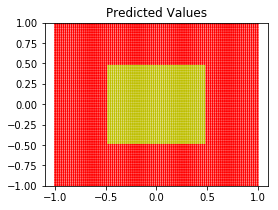

In [6]:
# (*) Step 5: Plotting
# Start the plot, 4x3in
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

# define plotting function
def ax_plot(ax, rand_var, title):
    # ax = axes object
    # rand_var = predictions
    # title = plot title
    
    # Get the mean of the predictiono, check whether > 0.5: this returns 0 or 1
    # Multiply by 2 and subtract 1, resulting in label of -1 or 1
    # Put the data on the cpu as a numpy array
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.cpu().numpy()
    # Define colors to use
    color = []
    for i in range(len(pred_labels)):
        # 1 are yellow, -1 are red
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    # Plot the data
    ax.scatter(test_x.data[:, 0].cpu().numpy(), test_x.data[:, 1].cpu().numpy(), color=color, s=1)
    ax.set_ylim([-1, 1])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Predicted Values')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GPWrapper),
])

with gpytorch.settings.use_toeplitz(False):
    pipe.fit(X=train_x, y=train_y)

  epoch    train_loss     dur
-------  ------------  ------
      1        5.7770  1.2286
      2        6.3175  1.0252
      3        4.7641  1.1603
      4        6.3622  1.1912
      5        3.2175  1.7821
      6        2.3577  1.0850
      7        2.9130  1.0431
      8        3.7824  1.0637
      9        3.1594  0.9886
     10        2.5416  1.0450
     11        1.8320  1.2317
     12        2.7012  1.3417
     13        1.9231  1.0841
     14        2.6443  1.4190
     15        2.5358  1.3902
     16        2.2186  1.2530
     17        2.6895  1.2803
     18        1.3788  1.0431
     19        1.6511  1.0622
     20        3.0547  1.0058
     21        1.9664  1.0403
     22        0.9962  1.0868
     23        0.8597  1.8127
     24        2.4362  1.0982
     25        2.4683  1.0613


# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}

GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
    max_epochs = 25,
    lr = 0.2
)

gs = GridSearchCV(GPWrapper, params, refit=False, cv=3, scoring='accuracy',
                 return_train_score=False)  # Use a different scoring function maybe?

with gpytorch.settings.use_toeplitz(False):
    gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1        7.4142  0.9957
      2        6.9941  0.8943
      3        6.6435  0.8026
      4        6.2637  0.8852
      5        6.1497  0.7935
      6        5.7345  0.8712
      7        5.5451  0.8411
      8        5.4060  0.8382
      9        5.2135  0.8340
     10        5.0590  0.8485
  epoch    train_loss     dur
-------  ------------  ------
      1        6.6230  1.5917
      2        6.2152  0.8310
      3        5.9035  0.8067
      4        5.7119  0.8992
      5        5.3055  0.9379
      6        5.1225  0.7078
      7        4.7207  0.7071
      8        4.6491  0.7044
      9        4.5825  0.8880
     10        4.1126  1.1398
  epoch    train_loss     dur
-------  ------------  ------
      1        7.3077  1.1364
      2        7.0919  1.0699
      3        6.5738  0.8778
      4        6.4203  0.9352
      5        6.2697  1.0001
      6        5.9636  0.7521
      7        5.7331  0.7252
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`